In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from spare_parts import get_company_list
from tradingview_ta import TA_Handler, Interval, Exchange
import ta


In [4]:
data_1 = pd.read_csv("paper-trading.csv")

In [5]:
data_1.tail(10)

Symbol  Side    Type  Qty     Price Fill Price  Status   
77         NSE:UBL  Sell  Market    1  1 535.00   1 535.00  Filled  \
78         NSE:UBL   Buy  Market   30  1 535.15   1 535.15  Filled   
79         NSE:UBL  Sell  Market   29  1 559.25   1 559.25  Filled   
80  NSE:APOLLOHOSP   Buy  Market    5  5 244.00   5 244.00  Filled   
81         NSE:BEL   Buy  Market   10    129.10     129.10  Filled   
82         NSE:BEL   Buy  Market   10    129.10     129.10  Filled   
83         NSE:BEL   Buy  Market   10    129.10     129.10  Filled   
84         NSE:ABB   Buy  Market   10  4 495.10   4 495.10  Filled   
85     NSE:SIEMENS  Sell  Market   10  3 754.55   3 754.55  Filled   
86  NSE:CUMMINSIND   Buy  Market   32  1 951.55   1 951.55  Filled   

    Commission         Placing Time         Closing Time   Order id  
77         NaN  2023-07-27 11:16:48  2023-07-27 11:16:48  911592713  
78         NaN  2023-07-27 11:16:55  2023-07-27 11:16:55  911592822  
79         NaN  2023-07-28 10:18:26  2023-07-28 10:18:26  913032013  
80         NaN  2023-07-28 10:22:00  2023-07-28 10:22:00  913034991  
81         NaN  2023-07-28 10:22:51  2023-07-28 10:22:51  913035776  
82         NaN  2023-07-28 10:22:52  2023-07-28 10:22:52  913035802  
83         NaN  2023-07-28 10:22:55  2023-07-28 10:22:55  913035835  
84         NaN  2023-07-28 10:23:13  2023-07-28 10:23:13  913036071  
85         NaN  2023-07-28 10:23:53  2023-07-28 10:23:53  913036622  
86         NaN  2023-07-28 11:03:47  2023-07-28 11:03:47  913068790

In [11]:
data_1['Symbol'].unique()

array(['NSE:ADANIENT', 'NSE:IGL', 'NSE:BAJAJFINSV', 'NSE:MRF', 'NSE:GAIL',
       'NSE:RELIANCE', 'NSE:TATAMOTORS', 'NSE:BEL', 'NSE:HDFCAMC',
       'NSE:SUNPHARMA', 'NSE:ONGC', 'NSE:SBILIFE', 'NSE:BRITANNIA',
       'NSE:PEL', 'NSE:HAL', 'NSE:DIVISLAB', 'NSE:ZYDUSLIFE', 'NSE:LT',
       'NSE:GRASIM', 'NSE:ZOMATO', 'NSE:BHARATFORG', 'NSE:SIEMENS',
       'NSE:UBL', 'NSE:APOLLOHOSP', 'NSE:ABB', 'NSE:CUMMINSIND'],
      dtype=object)

In [68]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Symbol        87 non-null     object 
 1   Side          87 non-null     object 
 2   Type          87 non-null     object 
 3   Qty           87 non-null     int64  
 4   Price         87 non-null     float64
 5   Fill Price    78 non-null     object 
 6   Status        87 non-null     object 
 7   Commission    0 non-null      float64
 8   Placing Time  87 non-null     object 
 9   Closing Time  87 non-null     object 
 10  Order id      87 non-null     int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 7.6+ KB


In [42]:
data_1['Price'].head(10)

0      2 426.85
1      2 430.85
2        493.20
3        492.35
4        494.35
5      1 619.15
6    102 480.10
7        109.40
8        495.10
9        510.10
Name: Price, dtype: object

In [64]:
def data_2(x):
    new_string = ""
    for i in x:
        if(i.isnumeric() or i == "."):
            new_string += i
    return float(new_string)



#data_1['Price']  = data_1['Price'].apply(data_2)

In [66]:
new_data = []
for i in data_1['Price'].to_list():
    data = data_2(i)
    new_data.append(data)

In [67]:
data_1['Price'] = new_data

0     2 426.85
1     2 430.85
2       493.20
3       492.35
4       494.35
        ...   
82      129.10
83      129.10
84    4 495.10
85    3 754.55
86    1 951.55
Name: Price, Length: 87, dtype: object

In [69]:
data_1[data_1['Symbol'] == "NSE:RELIANCE"].groupby("Side")[['Price', 'Qty']].sum()

Price  Qty
Side               
Buy   20847.45  180
Sell   5438.60  160

In [10]:
data_1[data_1['Order id'] == 908715948]

Symbol Side    Type  Qty   Price Fill Price  Status  Commission   
56  NSE:GAIL  Buy  Market  100  113.15     113.15  Filled         NaN  \

           Placing Time         Closing Time   Order id  
56  2023-07-25 09:59:09  2023-07-25 09:59:09  908715948

In [8]:
# main class
class bollinger_band:
    def __init__(self, ticker):
        self.ticker = ticker
        self.MAX_PROFIT_LIMIT = 0.2
        self.MAX_LOSS_LIMIT = -0.1
        self.current_position = 0
        self.output = 0
        self.positions = []
        self.logs = []
        # special - signal
        self.call = "" 
        self.signal = 0 # this signal changes once stock reaches the upper - bollinger band
    # define function
    def download_data(self):
        data_raw = yf.download(self.ticker+".NS", period="2y", interval = "1d")
        # calculating bollinger band
        volatile = ta.volatility.BollingerBands(data_raw['Close']) # type: ignore
        data_raw['bollinger_hband'] = volatile.bollinger_hband()
        data_raw['bollinger_lband'] = volatile.bollinger_lband()
        data_raw['bollinger_mavg'] = volatile.bollinger_mavg()
        data_raw['bollinger_pband'] = volatile.bollinger_pband()
        # calculating obv
        volatile_obv = ta.volume.OnBalanceVolumeIndicator(data_raw['Close'], data_raw['Volume']) #type: ignore
        data_raw['obv'] = volatile_obv.on_balance_volume()
        # calculating rsi
        data_raw['rsi'] = ta.momentum.RSIIndicator(data_raw['Close']).rsi() #type: ignore

        data_raw.dropna(inplace = True)
        data_raw['diff'] = data_raw['obv'].diff(periods=10) # slope
        print(data_raw.columns)
        self.data_list = data_raw.to_numpy()
        return data_raw
    
    def signal_check(self):
        self.download_data()
        main_list = self.data_list[-7:]
        for i in main_list:
            if(i[3] >= i[6]):
                self.signal = 1
        print(self.signal)
    # main function
    def run_test(self):
        self.signal_check()
        i = self.data_list[-1]
        

            # --
        try:
                current_node = i
                # buying section
                # checking the bollinger signal
                data = TA_Handler(
                    symbol= self.ticker,
                    exchange="NSE",
                    screener="india",
                    interval=Interval.INTERVAL_1_DAY
                )

                x = data.get_analysis().indicators #type: ignore

                if(self.signal == 1):
                    #----------------------------------------------------------------
                    if(current_node[12] > 0 and current_node[11] > 50):  # initally current_node[11] > 50
                        
                        print(x)
                        if(x['RECOMMENDATION'] == "STRONG_BUY"):
                            self.call = "buy"
                    # selling when stock crosses the lower bollinger band
                else:

                    if(current_node[3] < current_node[7]):
                        if(x['RECOMMENDATION'] == "STRONG_SELL"):
                            self.call = "sell"
        except:
            self.call = "sell"
            



In [9]:
bollinger_band("RELIANCE").run_test()

[*********************100%***********************]  1 of 1 completed
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'bollinger_hband', 'bollinger_lband', 'bollinger_mavg',
       'bollinger_pband', 'obv', 'rsi', 'diff'],
      dtype='object')
0


In [2]:
get_company_list = get_company_list()

In [3]:
get_company_list

(('Reliance Industries Limited', 'RELIANCE'),
 ('Tata Consultancy Services Limited', 'TCS'),
 ('HDFC Bank Limited', 'HDFCBANK'),
 ('Infosys Limited', 'INFY'),
 ('ICICI Bank Limited', 'ICICIBANK'),
 ('Hindustan Unilever Limited', 'HINDUNILVR'),
 ('State Bank of India', 'SBIN'),
 ('Bajaj Finance Limited', 'BAJFINANCE'),
 ('Housing Development Finance Corporation Limited', 'HDFC'),
 ('Bharti Airtel Limited', 'BHARTIARTL'),
 ('Kotak Mahindra Bank Limited', 'KOTAKBANK'),
 ('Wipro Limited', 'WIPRO'),
 ('HCL Technologies Limited', 'HCLTECH'),
 ('ITC Limited', 'ITC'),
 ('Adani Green Energy Limited', 'ADANIGREEN'),
 ('Asian Paints Limited', 'ASIANPAINT'),
 ('Bajaj Finserv Limited', 'BAJAJFINSV'),
 ('Adani Transmission Limited', 'ADANITRANS'),
 ('Avenue Supermarts Limited', 'DMART'),
 ('Larsen & Toubro Limited', 'LT'),
 ('Adani Total Gas Limited', 'ATGL'),
 ('Axis Bank Limited', 'AXISBANK'),
 ('Maruti Suzuki India Limited', 'MARUTI'),
 ('Titan Company Limited', 'TITAN'),
 ('Adani Enterprises Lim

In [11]:
data_1 = [i[1] for i in get_company_list]

In [12]:
dict_1 = {}
for i in data_1[500:1000]:
    try:
        target = bollinger_band(i)
        target.run_test()
        dict_1[i] = target.call
    except:
        pass


[*********************100%***********************]  1 of 1 completed
0
condtion not passed
[*********************100%***********************]  1 of 1 completed
0
condtion not passed
[*********************100%***********************]  1 of 1 completed
1
{'RECOMMENDATION': 'STRONG_BUY', 'BUY': 16, 'SELL': 0, 'NEUTRAL': 10}
[*********************100%***********************]  1 of 1 completed
0
condtion not passed
[*********************100%***********************]  1 of 1 completed
1
{'RECOMMENDATION': 'BUY', 'BUY': 15, 'SELL': 2, 'NEUTRAL': 9}
[*********************100%***********************]  1 of 1 completed
1
{'RECOMMENDATION': 'STRONG_BUY', 'BUY': 17, 'SELL': 0, 'NEUTRAL': 9}
[*********************100%***********************]  1 of 1 completed
1
{'RECOMMENDATION': 'STRONG_BUY', 'BUY': 16, 'SELL': 1, 'NEUTRAL': 9}
[*********************100%***********************]  1 of 1 completed
1
{'RECOMMENDATION': 'BUY', 'BUY': 14, 'SELL': 3, 'NEUTRAL': 9}
[*********************100%**************

In [13]:
x = pd.DataFrame(dict_1.items(), columns=['Company', 'Call'])

In [15]:
x[x['Call'] == 'buy'].to_csv("buy.csv")
print("hello world")

<h1>  r2 + macd data </h1>


In [21]:
# calculating r2 score
data_test = yf.download("TCS.NS", period="2y", interval = "1d")

[*********************100%***********************]  1 of 1 completed


In [22]:
import math
import numpy as np

def calculate_linear_regression_r2(source, length):
    # Calculate linear regression
    bar_index = np.arange(1, len(source) + 1)
    sumX = np.sum(bar_index[-length:])
    sumY = np.sum(source[-length:])
    sumX2 = np.sum(np.power(bar_index[-length:], 2))
    sumY2 = np.sum(np.power(source[-length:], 2))
    sumXY = np.sum(bar_index[-length:] * source[-length:])

    # Pearson correlation coefficient
    r = (length * sumXY - sumX * sumY) / math.sqrt((length * sumX2 - sumX ** 2) * (length * sumY2 - sumY ** 2))

    # Coefficient of determination (R2)
    r2 = r ** 2

    return r2

# Example usage
source = [10, 15, 13, 17, 20, 14, 18, 22, 25, 19, 23, 27, 30, 24, 28, 32, 35]
length = 5

r2 = calculate_linear_regression_r2(data_test['Close'], 14)
print(r2)
print("R2 score: {}".format(round(r2,1)))


0.4563371518751104
R2 score: 0.5


In [31]:
from spare_parts import get_company_list
data  = get_company_list()
final_list = {}

for i in data[:100]:
    try:
        data = yf.download(i[1]+".NS", period="2y", interval = "1d")
        r2 = calculate_linear_regression_r2(data['Close'], 14)
        macd_data = ta.trend.MACD(data['Close']).macd() #type: ignore
        macdsignal_data = ta.trend.MACD(data['Close']).macd_signal() #type: ignore
        ta_handler = TA_Handler(

            symbol = i[1],
            exchange="NSE",
            screener="india",
            interval=Interval.INTERVAL_1_DAY
            )
        x = ta_handler.get_analysis().summary #type: ignore
        
        if(r2 <= 0.05 and macd_data[-1] > macdsignal_data[-1]):
            #print(i[1])
            final_list[i[1]] = "BUY"
    except Exception as e:
        print(e)
        pass
    
        

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

C:\Users\hp\AppData\Local\Temp\ipykernel_14976\2611831631.py:14: RuntimeWarning: invalid value encountered in double_scalars
  r = (length * sumXY - sumX * sumY) / math.sqrt((length * sumX2 - sumX ** 2) * (length * sumY2 - sumY ** 2))


Exchange or symbol not found.
[*********************100%***********************]  1 of 1 completed
Exchange or symbol not found.
[*********************100%***********************]  1 of 1 completed
Exchange or symbol not found.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[************

C:\Users\hp\AppData\Local\Temp\ipykernel_14976\2611831631.py:14: RuntimeWarning: invalid value encountered in double_scalars
  r = (length * sumXY - sumX * sumY) / math.sqrt((length * sumX2 - sumX ** 2) * (length * sumY2 - sumY ** 2))


Exchange or symbol not found.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
MARICO
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Exchange or symbol not found.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%**********

In [32]:
final_list

{'VEDL': 'BUY', 'MARICO': 'BUY'}

In [47]:


def process_company_list(data,company_number):
    final_list = {}
    for i in data[:company_number]:
        try:
            data = yf.download(i[1]+".NS", period="60d", interval="60m")
            r2 = calculate_linear_regression_r2(data['Close'], 14)
            macd_data = ta.trend.MACD(data['Close']).macd()  # type: ignore
            macdsignal_data = ta.trend.MACD(data['Close']).macd_signal()  # type: ignore
            ta_handler = TA_Handler(
                symbol=i[1],
                exchange="NSE",
                screener="india",
                interval=Interval.INTERVAL_1_DAY
            )
            x = ta_handler.get_analysis().summary  # type: ignore

            if r2 <= 0.05 and macd_data[-1] > macdsignal_data[-1]:
                if(x['RECOMMENDATION'] == "STRONG_BUY" or x['RECOMMENDATION'] == "BUY"):
                    final_list[i[1]] = "BUY"
        except Exception as e:
            print(e)
            pass

    return final_list

# Example usage:
data = get_company_list()
result = process_company_list(data,350)
print(result)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

C:\Users\hp\AppData\Local\Temp\ipykernel_14976\2611831631.py:14: RuntimeWarning: invalid value encountered in double_scalars
  r = (length * sumXY - sumX * sumY) / math.sqrt((length * sumX2 - sumX ** 2) * (length * sumY2 - sumY ** 2))


Exchange or symbol not found.
[*********************100%***********************]  1 of 1 completed
Exchange or symbol not found.
[*********************100%***********************]  1 of 1 completed
Exchange or symbol not found.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[************

C:\Users\hp\AppData\Local\Temp\ipykernel_14976\2611831631.py:14: RuntimeWarning: invalid value encountered in double_scalars
  r = (length * sumXY - sumX * sumY) / math.sqrt((length * sumX2 - sumX ** 2) * (length * sumY2 - sumY ** 2))


Exchange or symbol not found.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Exchange or symbol not found.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*****************

C:\Users\hp\AppData\Local\Temp\ipykernel_14976\2611831631.py:14: RuntimeWarning: invalid value encountered in double_scalars
  r = (length * sumXY - sumX * sumY) / math.sqrt((length * sumX2 - sumX ** 2) * (length * sumY2 - sumY ** 2))


Exchange or symbol not found.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[***

C:\Users\hp\AppData\Local\Temp\ipykernel_14976\2611831631.py:14: RuntimeWarning: invalid value encountered in double_scalars
  r = (length * sumXY - sumX * sumY) / math.sqrt((length * sumX2 - sumX ** 2) * (length * sumY2 - sumY ** 2))


Exchange or symbol not found.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- RUCHI.NS: No data found, symbol may be delisted


C:\Users\hp\AppData\Local\Temp\ipykernel_14976\2611831631.py:14: RuntimeWarning: invalid value encountered in double_scalars
  r = (length * sumXY - sumX * sumY) / math.sqrt((length * sumX2 - sumX ** 2) * (length * sumY2 - sumY ** 2))


Exchange or symbol not found.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ZEEL.NS: No data found for this date range, symbol may be delisted


C:\Users\hp\AppData\Local\Temp\ipykernel_14976\2611831631.py:14: RuntimeWarning: invalid value encountered in double_scalars
  r = (length * sumXY - sumX * sumY) / math.sqrt((length * sumX2 - sumX ** 2) * (length * sumY2 - sumY ** 2))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MINDAIND.NS: No data found, symbol may be delisted


C:\Users\hp\AppData\Local\Temp\ipykernel_14976\2611831631.py:14: RuntimeWarning: invalid value encountered in double_scalars
  r = (length * sumXY - sumX * sumY) / math.sqrt((length * sumX2 - sumX ** 2) * (length * sumY2 - sumY ** 2))


Exchange or symbol not found.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[***

C:\Users\hp\AppData\Local\Temp\ipykernel_14976\2611831631.py:14: RuntimeWarning: invalid value encountered in double_scalars
  r = (length * sumXY - sumX * sumY) / math.sqrt((length * sumX2 - sumX ** 2) * (length * sumY2 - sumY ** 2))


Exchange or symbol not found.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[***

C:\Users\hp\AppData\Local\Temp\ipykernel_14976\2611831631.py:14: RuntimeWarning: invalid value encountered in double_scalars
  r = (length * sumXY - sumX * sumY) / math.sqrt((length * sumX2 - sumX ** 2) * (length * sumY2 - sumY ** 2))


Exchange or symbol not found.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[***

C:\Users\hp\AppData\Local\Temp\ipykernel_14976\2611831631.py:14: RuntimeWarning: invalid value encountered in double_scalars
  r = (length * sumXY - sumX * sumY) / math.sqrt((length * sumX2 - sumX ** 2) * (length * sumY2 - sumY ** 2))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
{'ABCAPITAL': 'BUY', 'KPRMILL': 'BUY', 'DCMSHRIRAM': 'BUY'}


<h1> plotting data </h1>

In [3]:
from recommend_stock import process_company_list

In [4]:
data = process_company_list(get_company_list(),11)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
x = data[1][0][0]

In [18]:
# convetting index to number
x.index = np.arange(0,len(x))

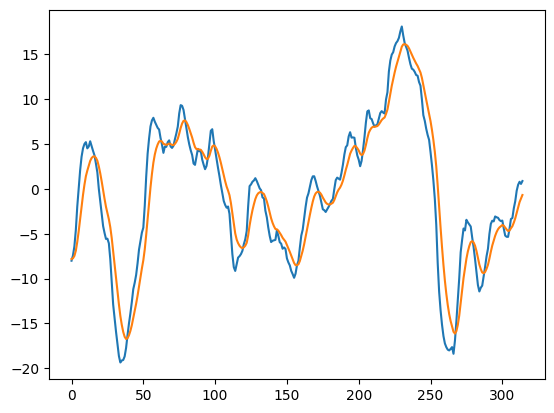

In [20]:
import matplotlib.pyplot as plt
plt.plot(x['macd'])
plt.plot(x['macd_signal'])

In [24]:
import numpy as np
import math
import pandas as pd

def calculate_linear_regression_r2(source, length):
    r2_values = np.empty_like(source)  # Create an empty array to store R2 values

    for i in range(length, len(source)):
        sub_source = source[i - length:i]

        bar_index = np.arange(1, len(sub_source) + 1)
        sumX = np.sum(bar_index)
        sumY = np.sum(sub_source)
        sumX2 = np.sum(np.power(bar_index, 2))
        sumY2 = np.sum(np.power(sub_source, 2))
        sumXY = np.sum(bar_index * sub_source)

        r = (length * sumXY - sumX * sumY) / math.sqrt((length * sumX2 - sumX ** 2) * (length * sumY2 - sumY ** 2))
        r2 = r ** 2

        r2_values[i] = r2  # Store the R2 value in the array

    return pd.Series(r2_values, index=source.index)  # Return a Series with R2 values for each value in the series



In [28]:
x['r2'] = calculate_linear_regression_r2(x['Close'],14)

<h1> generating 4-hour data </h1>

In [133]:
import yfinance as yf

# Download the 60-minute data
data_1 = yf.download("TCS.NS", period="60d", interval="60m")
columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Resample the data to 4-hour intervals
#data_4h = data_1.resample('4H').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last','Adj Close': 'last','Volume': 'sum'})

# Remove any rows with missing values
data_4h = data_1

# Print the resampled data


[*********************100%***********************]  1 of 1 completed


In [141]:
from tradingview_ta import TA_Handler, Interval, Exchange

In [175]:
data = TA_Handler(
    symbol = "ITC",
    exchange="NSE",
    screener="india",
    interval= Interval.INTERVAL_1_HOUR

)

In [176]:
x = data.get_analysis().summary

In [177]:
x['RECOMMENDATION']

'SELL'

In [8]:
x = 371
while(x > 0):
    data = x%10
    print(data)
    x -= data



1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


KeyboardInterrupt: 

In [10]:
300 % 10

0

<H1> us - stock </h1>

In [96]:
data_1 = yf.download("AAPL")

[*********************100%***********************]  1 of 1 completed


In [6]:
data_TA = TA_Handler(
                symbol = "AAPL",
                exchange="NASDAQ",
                screener="america",
                interval= Interval.INTERVAL_1_HOUR
                )
data_TA_4 = TA_Handler(
                symbol = "AAPL",
                exchange="NASDAQ",
                screener="america",
                interval= Interval.INTERVAL_4_HOURS
                )

data_1_day =  TA_Handler(
                symbol = "AAPL",
                exchange="NASDAQ",
                screener="america",
                interval= Interval.INTERVAL_1_DAY
                )

In [7]:
data_TA.get_analysis().summary

{'RECOMMENDATION': 'SELL', 'BUY': 2, 'SELL': 14, 'NEUTRAL': 10}

In [8]:
data_TA_4.get_analysis().summary

{'RECOMMENDATION': 'SELL', 'BUY': 6, 'SELL': 10, 'NEUTRAL': 10}

In [9]:
data_1_day.get_analysis().summary

{'RECOMMENDATION': 'NEUTRAL', 'BUY': 11, 'SELL': 5, 'NEUTRAL': 10}